In [1]:
import dataclasses

import jax
import jax.numpy as jnp
import pylab as plt
import tensorflow_probability.substrates.jax as tfp

from essm_jax.essm import ExtendedStateSpaceModel

tfpd = tfp.distributions


Let's define the dampled harmonic oscillator

$$m \ddot x= - c \dot x - k x + f(t)$$
$$\iff \ddot x = - 2 \zeta \omega \dot x - \omega^2 x + \frac{f(t)}{m}$$

with $\omega = \frac{k}{m} \in \mathbb{R}^+$, $\zeta = \frac{c}{2 \sqrt{mk}} \in \mathbb{R}^+$ and $f(t) \sim \mathcal{N}[0, \sigma_f^2]$.

Let us make this non-linear by supposing that $M = \log m \sim \mathcal{N}[\bar{M}, \sigma_M^2]$.

This defines a state,

$$ z = [x, v, M]$$

transition mean function,

$$ z_{t}, t \to [x + v \Delta t, v + (-c v - k x) \Delta t, \bar M]$$

transition noise scale function,

$$ z_{t}, t \to [0, \sigma_f, \sigma_M]$$

observation mean function,

$$ z_{t}, t \to [x, 0, 0]$$

and observation noise scale function,

$$ z_{t}, t \to [\sigma_x, 0, 0]$$


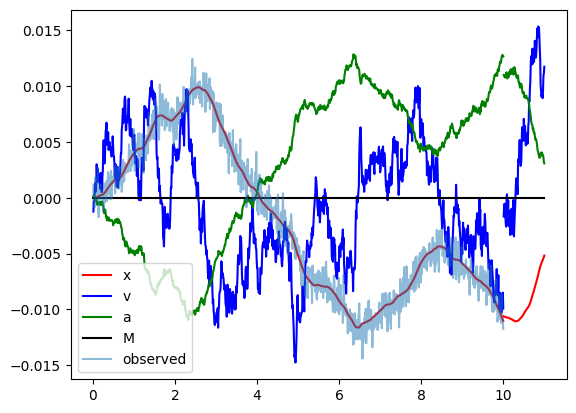

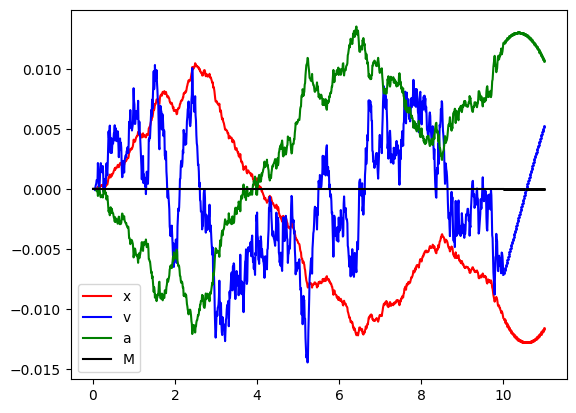

In [4]:

from essm_jax.pytee_utils import pytree_unravel
from typing import NamedTuple


class State(NamedTuple):
    """
    State for a single timestep of the Kalman filter.
    """
    x: jax.Array  # [n]
    v: jax.Array  # [n]
    a: jax.Array  # [n]
    M: jax.Array  # [n]


class Observation(NamedTuple):
    """
    Observables for a single timestep of the Kalman filter.
    """
    x: jax.Array  # [n]


n = 1  # Single dimension


@dataclasses.dataclass(eq=False)
class ExcitedDampedHarmonicOscillator:
    n: int = 1
    dt: float = 0.01
    sigma_f: float = 0.1
    sigma_x: float = 0.1
    zeta: float = 0.1
    omega: float = 1.
    m_bar: float = 1.

    def __post_init__(self):
        self.c = 2 * self.zeta * self.omega
        self.k = self.omega ** 2
        self.M_bar = jnp.log(self.m_bar)

        example_state = State(
            x=jnp.ones((n,)),
            v=jnp.ones((n,)),
            a=jnp.ones((n,)),
            M=jnp.ones((n,))
        )

        example_observation = Observation(
            x=jnp.ones((n,))
        )

        self.state_ravel_fn, self.state_unravel_fn = pytree_unravel(example_state)
        self.obs_ravel_fn, self.obs_unravel_fn = pytree_unravel(example_observation)

    def batched_state_ravel_fn(self, state: State) -> jax.Array:
        """
        Ravel a state with batched time axis into batched flat states.
        """
        # This is needed because calling ravel is only defined on the per element basis.
        return jax.vmap(self.state_ravel_fn)(state)

    def batched_state_unravel_fn(self, flat_state: jax.Array) -> State:
        """
        Unravel a batched flat state into a state with batched time axis.
        """
        # This is needed because calling unravel is only defined on the per element basis.
        return jax.vmap(self.state_unravel_fn)(flat_state)

    def batched_observables_ravel_fn(self, observation: Observation) -> jax.Array:
        """
        Ravel observables with batched time axis into batched flat observables.
        """
        # This is needed because calling ravel is only defined on the per element basis.
        return jax.vmap(self.obs_ravel_fn)(observation)

    def batched_observables_unravel_fn(self, flat_observables: jax.Array) -> Observation:
        """
        Unravel a batched flat observables into observables with batched time axis.
        """
        # This is needed because calling unravel is only defined on the per element basis.
        return jax.vmap(self.obs_unravel_fn)(flat_observables)

    def transition_fn(self, z: jax.Array, t: jax.Array, t_next) -> (tfpd.MultivariateNormalLinearOperator):
        dt = t_next - t
        state = self.state_unravel_fn(z)
        next_state_mean = State(
            x=state.x + state.v * dt,
            v=state.v + (-self.c * state.v - self.k * state.x) * dt,
            a=(-self.c * state.v - self.k * state.x),
            M=self.M_bar * jnp.ones_like(state.M)
        )
        next_state_scale = State(
            x=jnp.zeros_like(state.x),
            v=self.sigma_f * jnp.sqrt(dt) * jnp.ones_like(state.v),
            a=jnp.zeros_like(state.a),
            M=jnp.zeros_like(state.M)
        )
        return tfpd.MultivariateNormalDiag(self.state_ravel_fn(next_state_mean), self.state_ravel_fn(next_state_scale))

    def observation_fn(self, z: jax.Array, t: jax.Array) -> tfpd.MultivariateNormalLinearOperator:
        state = self.state_unravel_fn(z)
        obs_mean = Observation(
            x=state.x,
        )
        obs_scale = Observation(
            x=self.sigma_x * jnp.ones_like(state.x),
        )
        return tfpd.MultivariateNormalDiag(self.obs_ravel_fn(obs_mean), self.obs_ravel_fn(obs_scale))

    def create_initial_state_prior(self) -> tfpd.MultivariateNormalLinearOperator:
        initial_state = State(
            x=jnp.zeros((n,)),
            v=jnp.zeros((n,)),
            a=jnp.zeros((n,)),
            M=self.M_bar * jnp.ones((n,))
        )
        initial_state_scale = State(
            x=jnp.zeros((n,)),
            v=jnp.zeros((n,)),
            a=jnp.zeros((n,)),
            M=jnp.zeros((n,))
        )
        return tfpd.MultivariateNormalDiag(self.state_ravel_fn(initial_state), self.state_ravel_fn(initial_state_scale))

    def build_essm(self):
        return ExtendedStateSpaceModel(
            transition_fn=self.transition_fn,
            observation_fn=self.observation_fn,
            initial_state_prior=self.create_initial_state_prior(),
            more_data_than_params=False,
            dt=self.dt
        )


model = ExcitedDampedHarmonicOscillator(
    n=1,
    dt=0.01,
    sigma_f=0.01,
    sigma_x=0.001,
    zeta=0.1,
    omega=1.,
    m_bar=1.
)

essm = model.build_essm()

samples = essm.sample(key=jax.random.PRNGKey(0), num_time=1000)

obs = model.batched_observables_unravel_fn(samples.observation)
state = model.batched_state_unravel_fn(samples.latent)
plt.plot(samples.t, state.x, label='x', c='r')
plt.plot(samples.t, state.v, label='v', c='b')
plt.plot(samples.t, state.a, label='a', c='g')
plt.plot(samples.t, state.M, label='M', c='k')
plt.plot(samples.t, obs.x, label='observed', alpha=0.5)

filter_result = essm.forward_filter(observations=samples.observation)

future_samples = essm.forward_simulate(key=jax.random.PRNGKey(0), num_time=100, filter_result=filter_result)
future_latent = model.batched_state_unravel_fn(future_samples.latent)
plt.plot(future_samples.t, future_latent.x, c='r')
plt.plot(future_samples.t, future_latent.v, c='b')
plt.plot(future_samples.t, future_latent.a, c='g')
plt.plot(future_samples.t, future_latent.M, c='k')
plt.legend()
plt.show()

filter_latent = model.batched_state_unravel_fn(filter_result.filtered_mean)
plt.plot(filter_result.t, filter_latent.x, label='x', c='r')
plt.plot(filter_result.t, filter_latent.v, label='v', c='b')
plt.plot(filter_result.t, filter_latent.a, label='a', c='g')
plt.plot(filter_result.t, filter_latent.M, label='M', c='k')

filter_state = essm.create_filter_state(filter_result=filter_result)
for _ in range(100):
    filter_state = essm.incremental_predict(filter_state=filter_state)
    latent = model.state_unravel_fn(filter_state.filtered_mean)
    plt.scatter(filter_state.t, latent.x, c='r', s=1)
    plt.scatter(filter_state.t, latent.v, c='b', s=1)
    plt.scatter(filter_state.t, latent.a, c='g', s=1)
    plt.scatter(filter_state.t, latent.M, c='k', s=1)

plt.legend()
plt.show()

